In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.3, 0.3, '한글')

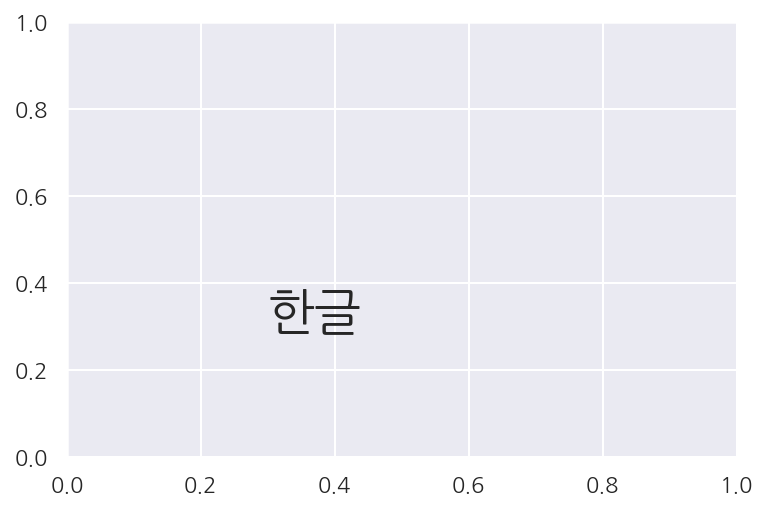

In [1]:
import os
import re
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns

!pip install --upgrade matplotlib               # ‘AxesSubplot’ object has no attribute ‘bar_label’ 오류 해결을 위한 업데이트
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd


# 폰트 설정
%config InlineBackend.figure_format = 'retina'
!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'      # 나눔 고딕
font_name = fm.FontProperties(fname=path, size=10).get_name() # 기본 폰트 사이즈 : 10
plt.rc('font', family=font_name)
sns.set(font=font_name, rc={"axes.unicode_minus":False}, style='darkgrid')
# fm._rebuild()

plt.text(0.3, 0.3, '한글', size=25)

In [2]:
memo_file_path = '/content/drive/MyDrive/02_AIFFEL/aiffelTon/Wordcloud/data_for_wordcloud/memo_hackathon_lesion_info_table.tsv'
stop_words_path = '/content/drive/MyDrive/02_AIFFEL/aiffelTon/Wordcloud/data_for_wordcloud/stopword.txt'
qna_nogari_path = '/content/drive/MyDrive/02_AIFFEL/aiffelTon/Wordcloud/data_for_wordcloud/Q_A_Category_for_wordcloud.csv'

df_memo = pd.read_csv(memo_file_path, index_col=0)
# df_memo.head()

### 문의 & 안내 & 라벨 추출

In [ ]:
# 정규표현식으로 "문의내용" 추출 함수 정의
def regularexp_query(string):
    
    string = string.replace(':', ' ').replace('\n', ' ').replace('ob', ' ')    
    # 정규표현식 사용
    regular = re.compile('(?<=퀘션[해사 ][퀘션사항 ][용항 ])(.*?)(?=[ㅁ확종긍])') # 비식별화된 내용입니다.

    result1 = regular.search(string).group()
    result2 = re.sub('[^가-힣 ]+', ':', result1).split(':')

    list_query = []
    for sentence in result2:
        if sentence == '' or sentence == ' ': continue
        sentence = sentence.strip()
        list_query.append(sentence)

    return list_query


# 정규표현식으로 "안내내용" 추출 함수 정의
def regularexp_guide(string):
    string = string.replace(':', ' ').replace('\n', ' ').replace('  ', ' ')
    string = string + 'ㅁ'
    
    reg_long = re.compile('(?<=앤서[/엔내][엔드내용약][리내용사속 ][항내용 ][내용 ][용 ])(.*?)(?=[ㅁ※])') # 비식별화된 내용입니다.
    reg_short = re.compile('(?<=(앤서|엔드)[내사][용항])(.*?)(?=[ㅁ※])')  # 비식별화된 내용입니다.

    try:
        result1 = reg_long.search(string).group()
        result2 = re.sub('[^가-힣0-9 ]+', ':', result1).split(':')
    except AttributeError:
        result1 = reg_short.search(string).group()
        result2 = re.sub('[^가-힣0-9 ]+', ':', result1).split(':')

    list_query = []
    for sentence in result2:
        if sentence == '' or sentence == ' ': continue
        sentence = sentence.strip()
        list_query.append(sentence)

    return list_query


# 라벨에 넣을 카데고리 추출 함수
def category_detail(detail):
    detail = detail.replace("/", " ").replace("(", " ").replace(")", "").replace(",", " ").replace("_", " ").replace("  ", " ").split()
    return detail[0]
    

# 문의내용있는 행 인덱스 추출 
query_words = ['퀘션내용', 'ㅁ퀘션내용', '퀘션 내용',
               'ㅁ퀘션', '퀘션사항', 'ㅁ퀘션사항', '퀘션 사항', '퀘션구분'] # 비식별화된 내용입니다.
confirm_words = ['앤서/엔드 내용', '앤서/엔드내용', '앤서내용',
                 '엔드내용', '앤서사항', '앤서/엔드사항']  # 비식별화된 내용입니다.
index = []
for idx, row in df_memo.iterrows():
    memo = str(row[8])
    for query_word in query_words:
        for confirm_word in confirm_words:
            if query_word in memo and confirm_word in memo:
                index.append(idx)

index = sorted(list(set(index)))
print(len(index))

# 문의내용 추출 후 query 컬럼에 넣기
key_df = df_memo.loc[index]
key_df = key_df.reset_index()

key_df['query'] = 0
key_df['guide'] = 0
key_df['label_word'] = 0 # 카테고리 또는 키워드


for idx in range(len(key_df)):
    str1 = regularexp_query(key_df['memo'][idx])
    str2 = regularexp_guide(key_df['memo'][idx])
    str3 = category_detail(key_df['lesion_detail_type'][idx])
    
    key_df['query'][idx] = str1
    key_df['guide'][idx] = str2
    key_df['label_word'][idx] = str3

### Q, A, Label 형태인 데이터프레임 만들기

In [4]:
def q_a_label(df):
    df_qna = pd.DataFrame(columns = {'category', 'Q', 'A'}) # 빈 데이터프레임 만들기
    df_qna = df_qna[['category', 'Q', 'A']]                 # 위에 빈 데이터프레임을 만들었는데 컬럼 순서대로 나오지 않아서 강제로 다시 컬럼 순서를 정렬함
    for idx, row in tqdm(df.iterrows()):
        querys = row['query']
        guides = row['guide']
        category = row['lesion_detail_type']
        
        for query in querys:
            for guide in guides:
                new_data = {'category': category, 'Q': query, 'A': guide}
                new_df = pd.DataFrame.from_dict([new_data])
                df_qna = pd.concat([df_qna, new_df])

    df_qna = df_qna.drop_duplicates()                # 중복 제거
    df_qna = df_qna.dropna(axis=0)                   # 결측치 제거
    df_qna = df_qna.reset_index(drop=True)           # 인덱스 생성
    
    # category 단어에서 불필요한 특수문자 없애기
    for idx in range(len(df_qna['category'])):
        detail = df_qna['category'][idx]
        detail = detail.replace('_', ' ')
        df_qna['category'][idx] = detail
    
    return df_qna

df_qna = q_a_label(key_df)

14577it [08:23, 28.97it/s]


In [ ]:
# 저장
# df_qna.to_csv(qna_nogari_path, index=False, encoding='utf-8-sig') # utf-8은 한글깨짐이 발생하므로 utf-8-sig로 변경

# 불러오기
qkey_df = pd.read_csv(qna_nogari_path, encoding='utf-8-sig')
qkey_df.head()

In [ ]:
# 카테고리에서 같은 의미 다른 단어를 하나의 의미로 통일
for idx, cat in enumerate(qkey_df['category']):
    qkey_df['category'][idx] = cat.replace('산소 부족', '부족 산소') \
        .replace('이산화탄소 과다', '과다 이산화탄소') # 비식별화된 내용입니다.

In [ ]:
# 첫번째 대분류 단어만 추출하기
for idx, words in enumerate(qkey_df['category']):
    category = words.split()[0]
    qkey_df['category'][idx] = category

In [ ]:
# 문의내용(Q) 중에서 같은 문장이면 하나의 문의에 속하므로 같은 문장들은 1개의 문의로 만듦
Q_sent = []
first_idxes = []
prev = None
for idx, sent in enumerate(qkey_df['Q']):
    if prev == sent: continue
    Q_sent.append(sent)
    prev = sent
    first_idxes.append(idx)
print(len(Q_sent))

qkey_df = qkey_df.loc[first_idxes].reset_index(drop=True)
# qkey_df

9182


In [ ]:
# 카테고리 개수 세기
count_category = {}
for category in qkey_df['category']:
    if category not in count_category:
        count_category[category] = 1
    else:
        count_category[category] += 1

sorted_category = sorted(count_category.items(), key=lambda x: x[1], reverse=True)
# print(sorted_category)

In [ ]:
# 불용어파일을 리스트로 만들기
with open(stop_words_path, "r") as f:
    lines = f.readlines()
    remove_from_stopwords = ['어디\n', '이상\n']                                                             # 불용어 리스트에서 해당 단어 제거하기. 즉 사용할 단어임
    stop_words = [line.strip() for line in lines if line not in remove_from_stopwords]
    stop_words = list(set(stop_words))
    print('불용어 개수 :', len(stop_words))

불용어 개수 : 751


In [ ]:
# 쏘카 데이터 보안 때문에 다른 단어로 대체하기 위한 함수
def category_change(df):
    # 지구 지각 원소량에 따른 원소들 
    elements = ['산소', '실리콘', '알루미늄', '철', '칼슘', '소듐', '마그네슘', '포타슘', '티타늄', '수소', '인', '망간', '칼륨', '티타늄', '플로오린', '바륨', '스트론티늄', '황', 
                '탄소', '루비듐', '니켈', '아연', '세륨', '구리', '네오디움', '란타넘', '이트륨', '질소', '코발트', '스칸듐', '리튬', '나이오븀', '갈륨', '납', '붕소', '토륨', '프라세오디움',
                '사마륨', '가돌리늄', '디스프로슘', '어븀', '아르곤', '이터븀', '하프늄', '세슘', '베릴륨', '우라늄', '브롬', '주석', '탄탈륨', '유로퓸']

    cate_change = {}
    for idx, word in enumerate(sorted_category):
        cate_change[word[0]] = elements[idx]

    for idx, cate in enumerate(df['category']):
        df['category'][idx] = cate_change[cate]

    return df

qkey_df = category_change(qkey_df)
# print(qkey_df)

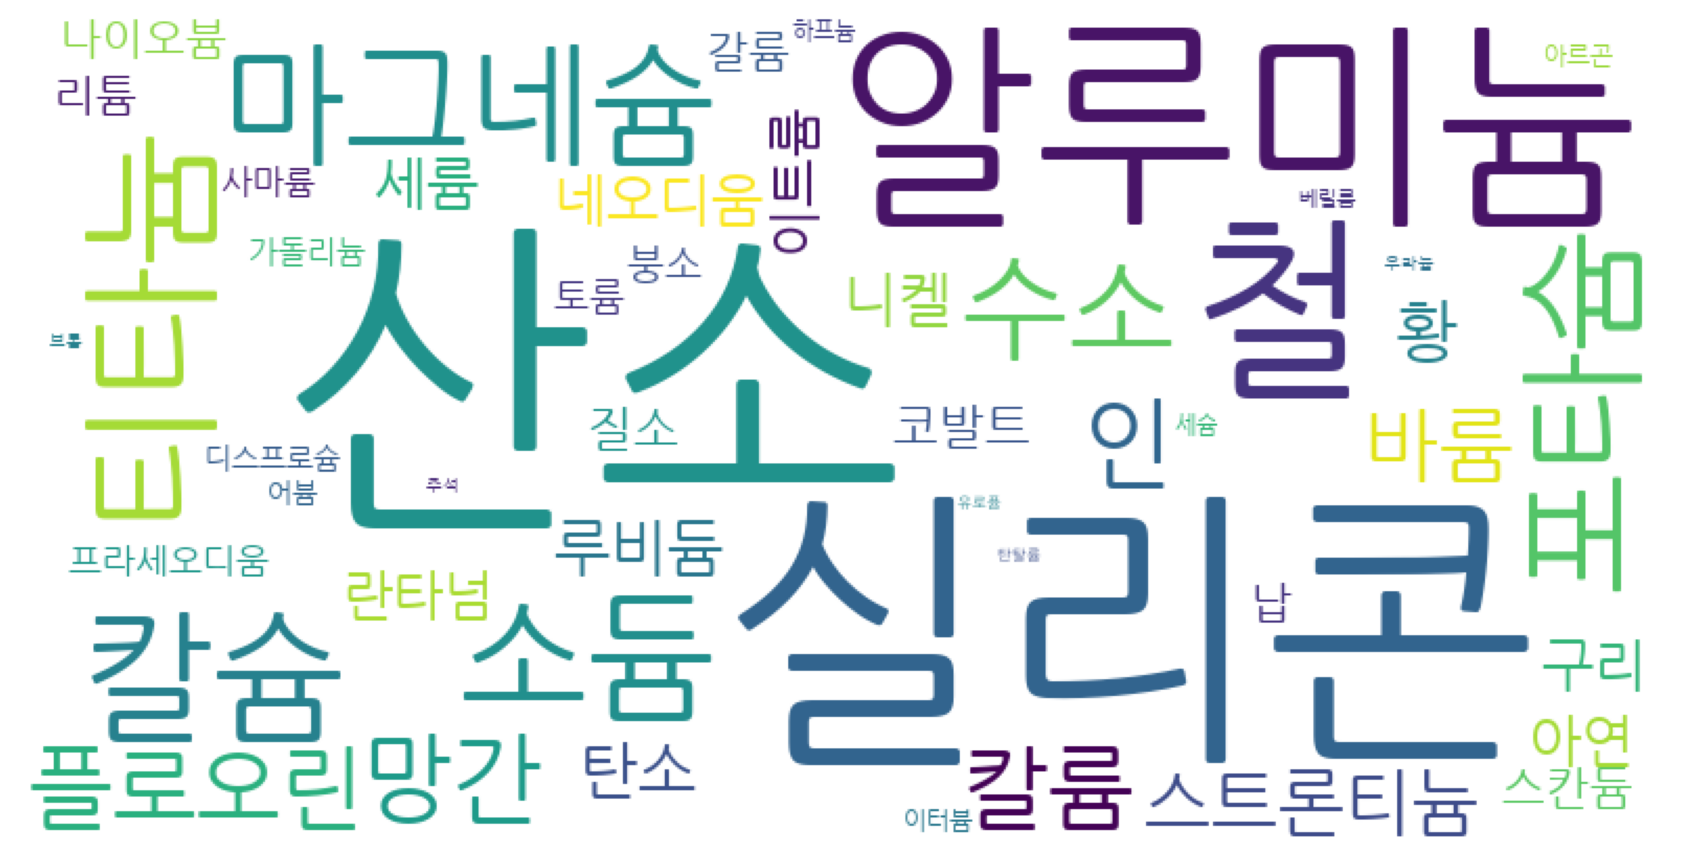

In [ ]:
categories = list(qkey_df['category'])

# 한국어 불용어 사전을 정의
stopwords = set(stop_words)

# CREATE WORDCLOUD
wc = WordCloud(
    font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    background_color='white',
    collocations=False,
    stopwords=stopwords,
    width=800, 
    height=400)
wc.generate(' '.join(categories))

# Plot wordcloud
plt.figure(figsize=(15,10)) # plot size
plt.imshow(wc) 
plt.axis('off')             # axis delete
plt.show()

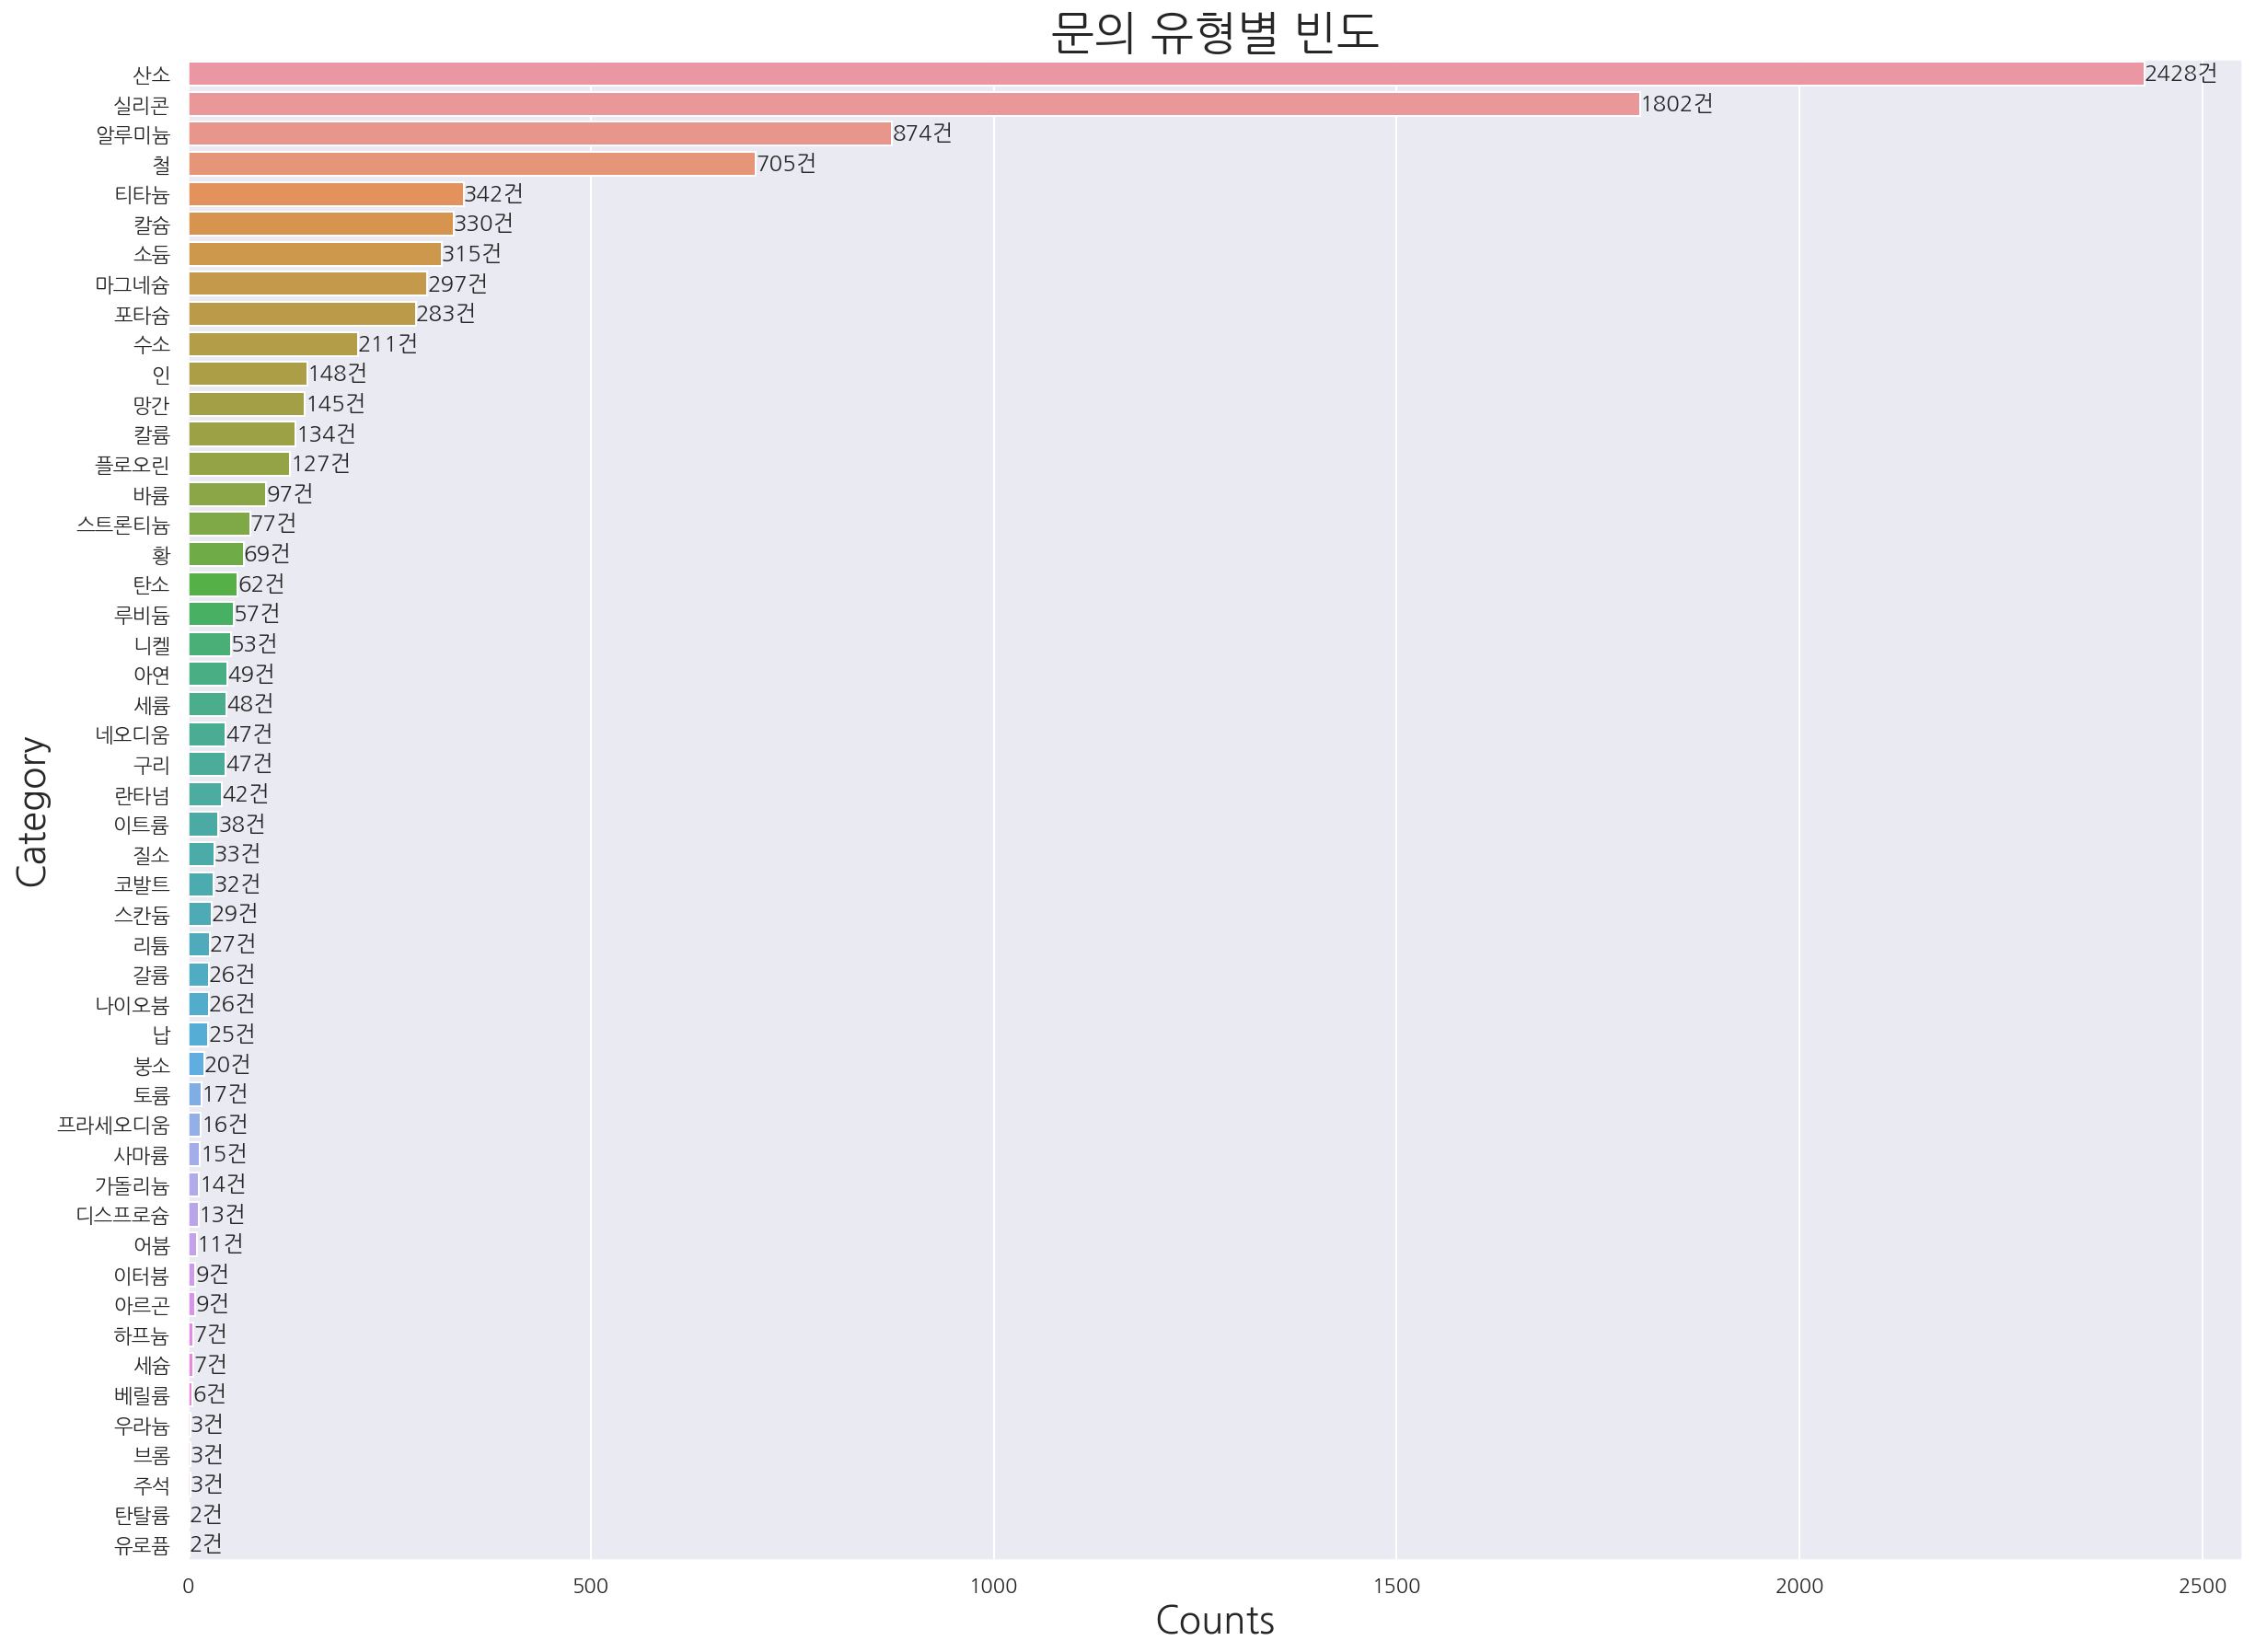

In [ ]:
group = qkey_df.groupby(["category"]).count().sort_values(by = "Q", ascending = False)
plt.figure(figsize = (20, 15))
ax = sns.countplot(data = qkey_df, y = "category", order = qkey_df['category'].value_counts().index)

# 레이블
ax.bar_label(ax.containers[0], fmt='%.0f건')

# 그래프 제목
plt.title("문의 유형별 빈도", fontsize = 25)

# 축 이름 바꾸기
plt.xlabel("Counts", fontsize = 20)
plt.ylabel("Category", fontsize = 20)

plt.show()